In [1]:
import glob
import astropy.io.fits as fits
from astropy.time import Time 
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pickle
import pandas as pd
import os
import time

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
from matplotlib import cm

from astropy.visualization import ZScaleInterval

%matplotlib inline

In [3]:
i = "/data/imageport_imager/2017-02-25T05:08:50-S298-B15.fits"
data, f=fits.getdata(i,header=True)
fitsimg = fits.getdata(i,header=True)

In [4]:
x = ZScaleInterval()

In [5]:
(zmin, zmax) = x.get_limits(data[0,0,:,:])
print(zmin, zmax)

(-57.330779245425688, 57.516468649574279)


/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


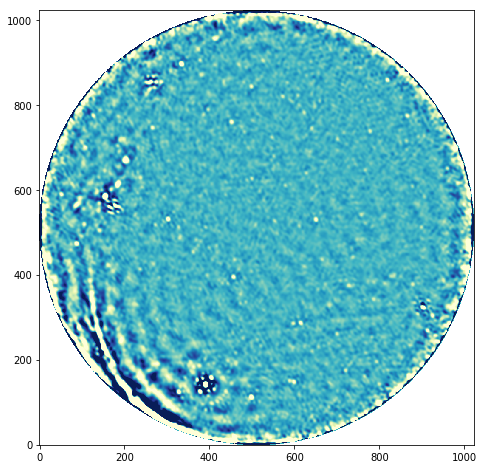

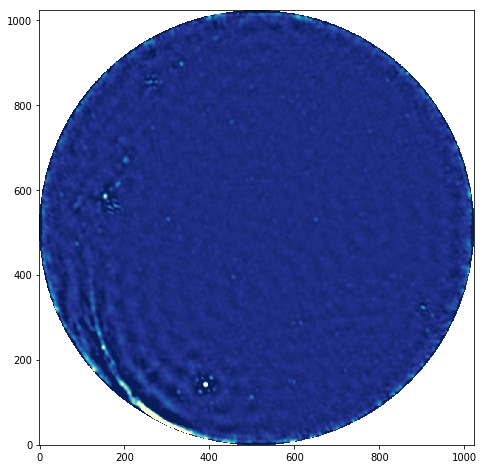

In [6]:
plt.figure(figsize=(8,8))
plt.imshow(data[0,0,:,:], vmin=zmin, vmax=zmax,origin="lower",cmap="YlGnBu_r")

img = data[0,0,:,:]
mean = np.nanmean(img)
std = np.nanstd(img)
imin = mean - 0.5*std
imax = mean + 5*std
img[img < imin] = imin
img[img > imax] = imax
plt.figure(figsize=(8,8))
plt.imshow(img, origin="lower",cmap="YlGnBu_r")



/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in less
/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater
/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


(-28.665389622712844, 115.03293729914856)
0.144806146622


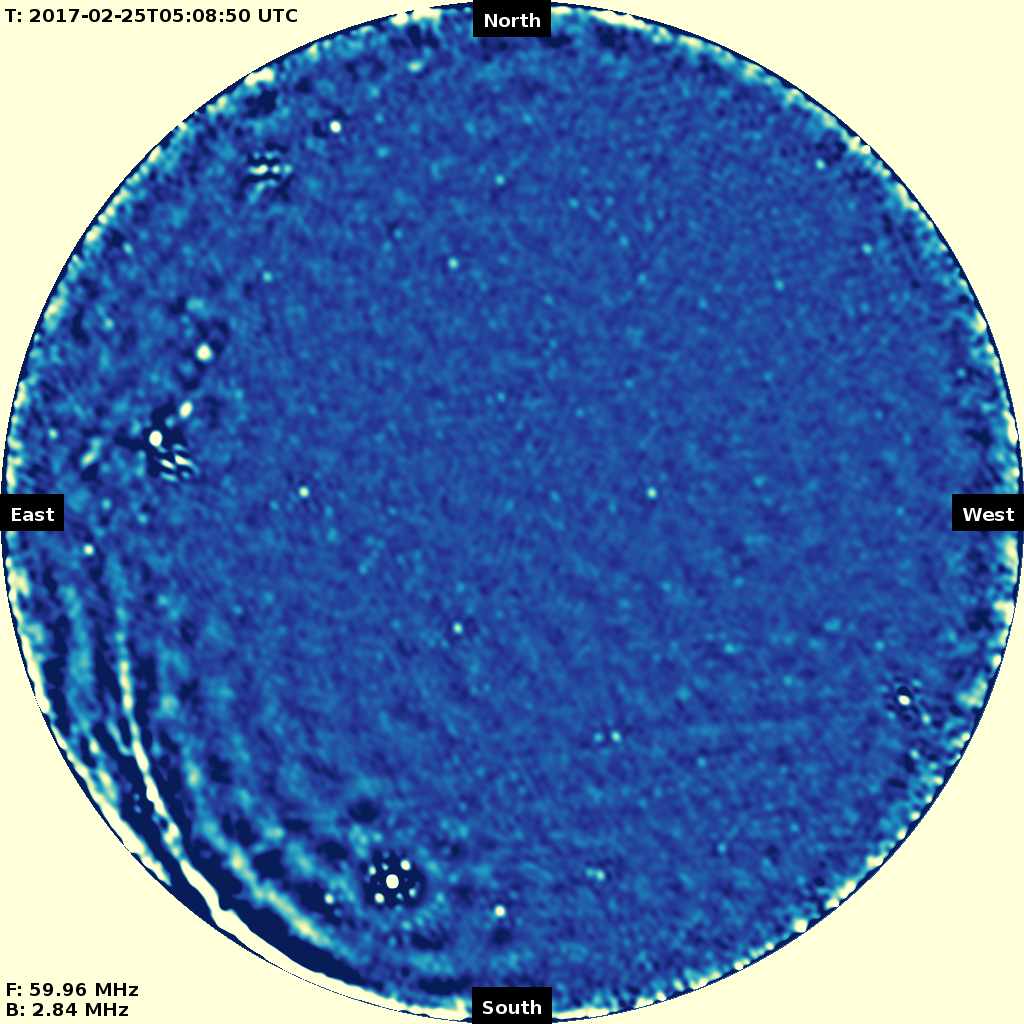

In [8]:
# from matplotlib import cm
# from PIL import Image
# from PIL import ImageFont
# from PIL import ImageDraw

def rms(data):
    """Returns the RMS of the data about the median.
    Args:
        data: a numpy array
    """
    data -= np.nanmedian(data)
    return np.sqrt(np.power(data, 2).sum()/len(data))


def clip(data, sigma=3):
    """Remove all values above a threshold from the array.
    Uses iterative clipping at sigma value until nothing more is getting clipped.
    Args:
        data: a numpy array
    """
    raveled = data.ravel()
    median = np.nanmedian(raveled)
    std = np.nanstd(raveled)
    newdata = raveled[np.abs(raveled-median) <= sigma*std]
    if len(newdata) and len(newdata) != len(raveled):
        return clip(newdata, sigma)
    else:
        return newdata
    
i = "/data/imageport_imager/2017-02-25T05:08:50-S298-B15.fits"
# i = "/data/20170823/2017-08-23T08:53:33-S175-B15.fits"
data, f=fits.getdata(i,header=True)
fitsimg = fits.getdata(i,header=True)

time1 = time.time()
font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 18)
font_label = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 16)


font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 18)
IMAGE_RES = 1024
SOURCES = ['Cas.A', 'Cyg.A', 'Tau.A', 'Vir.A', 'Sun', 'Moon']

t = Time(f['DATE-OBS'])
# self.constellations.update(t.datetime, IMAGE_RES/2)
# self.num_processing += 1
img = data[0,0,::-1,:]

(imin, imax) = ZScaleInterval().get_limits(data[0,0,:,:])
imax *=2
imin *=0.5

#mean = np.nanmean(img) #np.nanmean(clip(img[~np.isnan(img)]))
#std = np.nanstd(img)  #rms(clip(img[~np.isnan(img)])) #np.nanstd(img)
#imin = mean - 0.5*std
#imax = mean + 4*std

img[img < imin] = imin
img[img > imax] = imax
print(imin,imax)
img -= imin
img *= (1.0 / (imax-imin))
pilimg = Image.fromarray(np.uint8(cm.YlGnBu(1.0-img)*255))

draw = ImageDraw.Draw(pilimg)
draw.text((5,  5), 'T: %s UTC' % f['DATE-OBS'], (0, 0, 0), font=font)
draw.text((5, IMAGE_RES-45), 'F: %0.2f MHz' % (f['RESTFRQ']*1e-6), (0, 0, 0), font=font)
draw.text((5, IMAGE_RES-25), 'B: %0.2f MHz' % (f['RESTBW']*1e-6), (0, 0, 0), font=font)


from PIL import Image, ImageDraw

#font = ImageFont.truetype("arial")

text = "North"
text_size = font.getsize(text)
button_size = (text_size[0]+20, text_size[1]+20)
button_img = Image.new('RGBA', button_size, "black")
button_draw = ImageDraw.Draw(button_img)
button_draw.text((10, 10), text, font=font)
pilimg.paste(button_img, (IMAGE_RES/2-(button_size[0]/2), 0))

text = "South"
text_size = font.getsize(text)
button_size = (text_size[0]+20, text_size[1]+20)
button_img = Image.new('RGBA', button_size, "black")
button_draw = ImageDraw.Draw(button_img)
button_draw.text((10, 10), text, font=font)
pilimg.paste(button_img, (IMAGE_RES/2-(button_size[0]/2), IMAGE_RES-(button_size[1])))

text = "West"
text_size = font.getsize(text)
button_size = (text_size[0]+20, text_size[1]+20)
button_img = Image.new('RGBA', button_size, "black")
button_draw = ImageDraw.Draw(button_img)
button_draw.text((10, 10), text, font=font)
pilimg.paste(button_img, (IMAGE_RES-(button_size[0]), IMAGE_RES/2-button_size[1]/2))

text = "East"
text_size = font.getsize(text)
button_size = (text_size[0]+20, text_size[1]+20)
button_img = Image.new('RGBA', button_size, "black")
button_draw = ImageDraw.Draw(button_img)
button_draw.text((10, 10), text, font=font)
pilimg.paste(button_img, (0, IMAGE_RES/2-button_size[1]/2))






print time.time()-time1
# for name in SOURCES:
#     p = self.constellations.source(name)
#     if p != None:
#         e = (p[0]+10, p[1]+10)
#         draw.line(xy=[p, e], fill=(255, 255, 0))
#         draw.text(e, name, (255, 255, 0), font=font_label)

# for name in CONSTELLATIONS:
#     c = self.constellations.const(name)
#     draw.line(xy=c, fill=(255, 255, 0), width=2)
pilimg


In [131]:
# pilimg
mask = np.nan*np.zeros([1024,1024], dtype=int)
mask[np.isnan(data[0,0,:,:])] = 1


PIL_mask = Image.fromarray(np.uint8(cm.Greys(mask)*255))
PIL_alpha = Image.fromarray(np.uint8(cm.Greys(np.ones([1024,1024]))*255))

#PIL_mask
comp_img = Image.blend(pilimg, PIL_mask, 0.5)

# comp_img
#pillow show image
# PIL_mask.size
a_channel = Image.new('L', pilimg.size, 255)

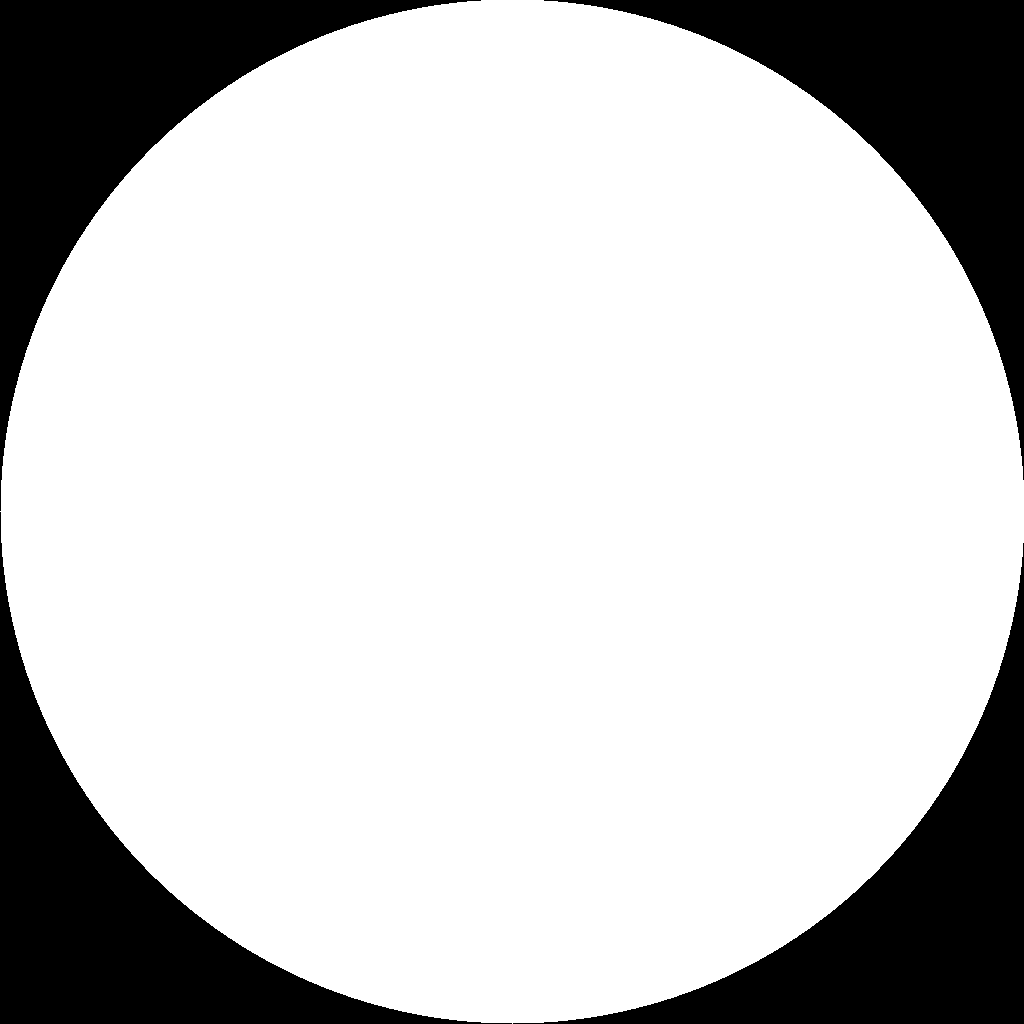

In [135]:
PIL_mask

/afhome/kuiack/venv/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in less
/afhome/kuiack/venv/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


(-22.57877516746521, 242.89036583900452)
0.112533092499


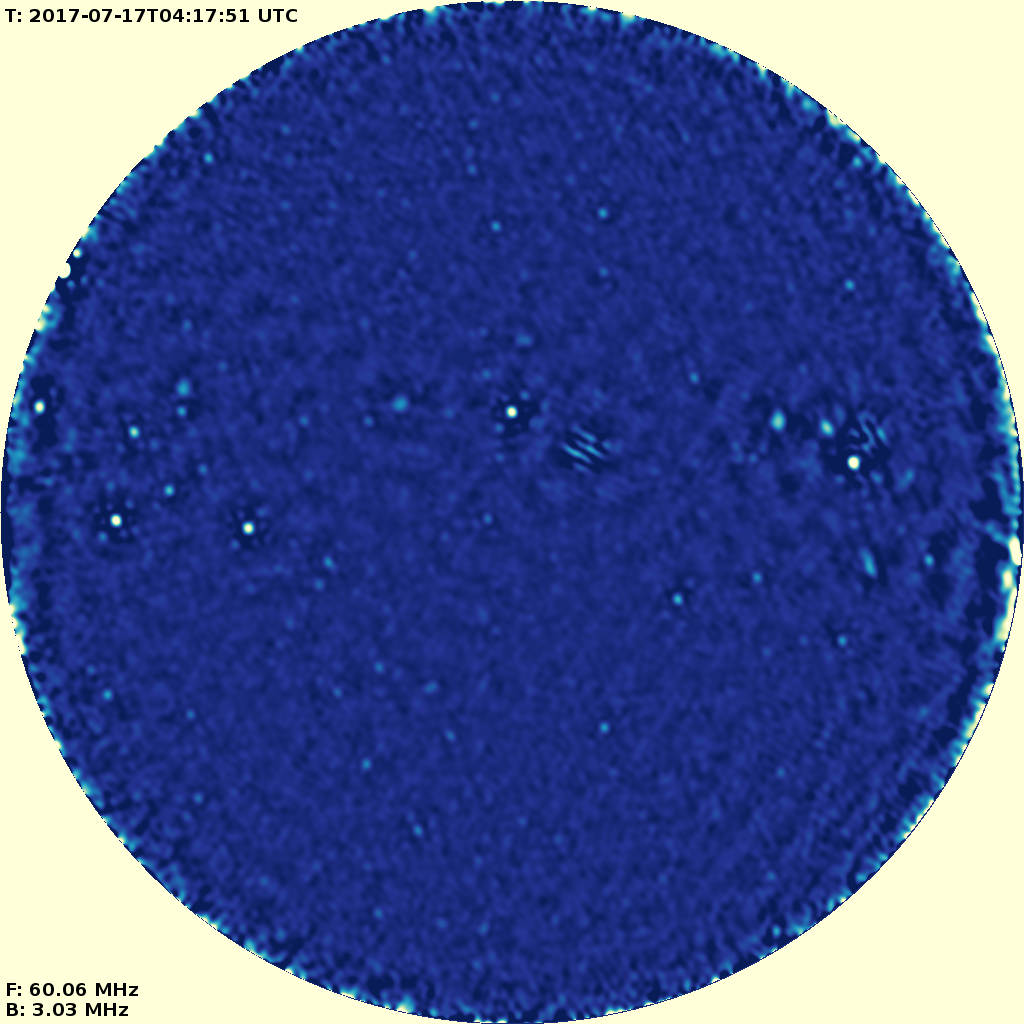

In [49]:
# i = "/data/20170823/2017-08-23T08:53:33-S175-B15.fits"
i = "/data/20170717/2017-07-17T04:17:51-S298-B16.fits"

data, f=fits.getdata(i,header=True)
fitsimg = fits.getdata(i,header=True)

time1 = time.time()
font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 18)
font_label = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 16)


font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 18)
IMAGE_RES = 1024
SOURCES = ['Cas.A', 'Cyg.A', 'Tau.A', 'Vir.A', 'Sun', 'Moon']

t = Time(f['DATE-OBS'])
# self.constellations.update(t.datetime, IMAGE_RES/2)
# self.num_processing += 1
img = data[0,0,::-1,:]

# (imin, imax) = x.get_limits(data[0,0,:,:])
# imax *=1.5
# imin *=.5
mean = np.nanmean(img) #np.nanmean(clip(img[~np.isnan(img)]))
std = np.nanstd(img)  #rms(clip(img[~np.isnan(img)])) #np.nanstd(img)
imin = mean - 0.5*std
imax = mean + 5*std
img[img < imin] = imin
img[img > imax] = imax
print(imin,imax)
img -= imin
img *= (1.0 / (imax-imin))
pilimg = Image.fromarray(np.uint8(cm.YlGnBu(1.0-img)*255))
draw = ImageDraw.Draw(pilimg)
draw.text((5,  5), 'T: %s UTC' % f['DATE-OBS'], (0, 0, 0), font=font)
draw.text((5, IMAGE_RES-45), 'F: %0.2f MHz' % (f['RESTFRQ']*1e-6), (0, 0, 0), font=font)
draw.text((5, IMAGE_RES-25), 'B: %0.2f MHz' % (f['RESTBW']*1e-6), (0, 0, 0), font=font)
print time.time()-time1
# for name in SOURCES:
#     p = self.constellations.source(name)
#     if p != None:
#         e = (p[0]+10, p[1]+10)
#         draw.line(xy=[p, e], fill=(255, 255, 0))
#         draw.text(e, name, (255, 255, 0), font=font_label)

# for name in CONSTELLATIONS:
#     c = self.constellations.const(name)
#     draw.line(xy=c, fill=(255, 255, 0), width=2)
pilimg

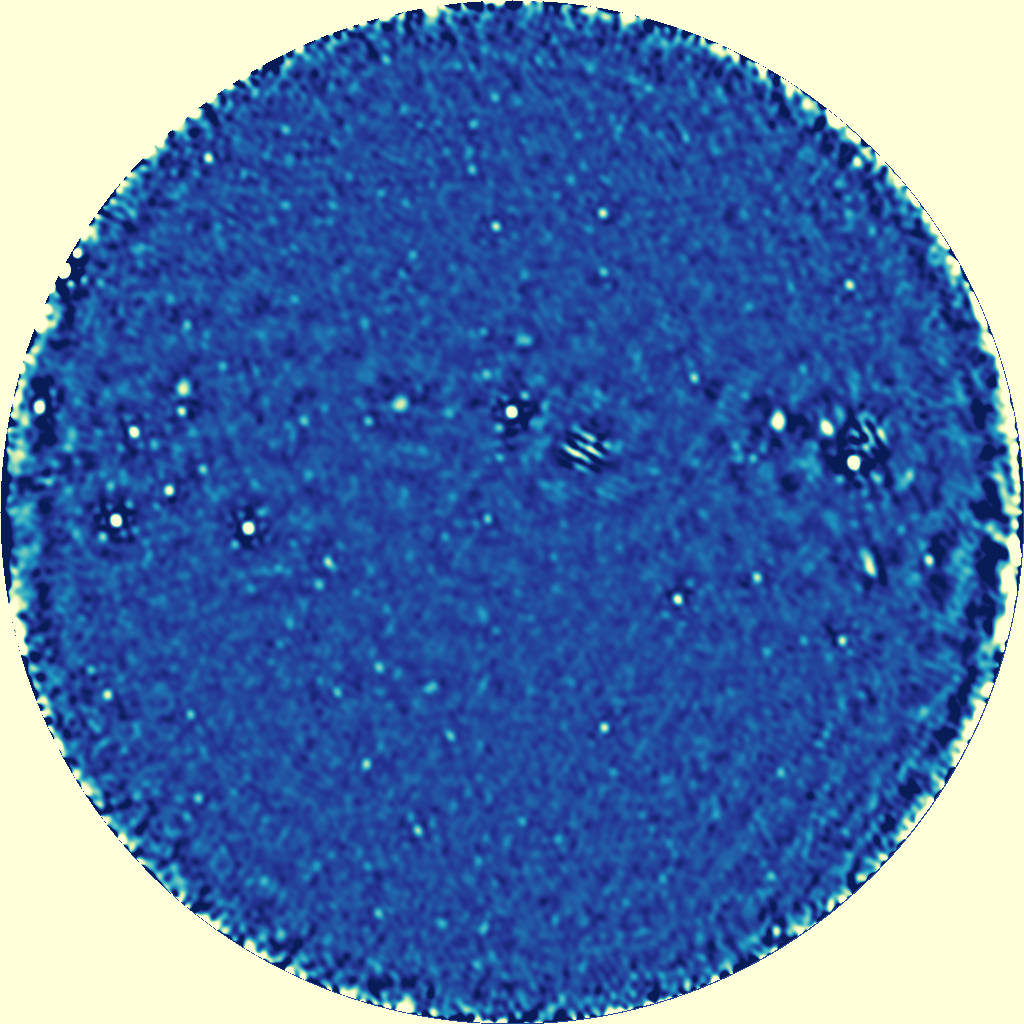

In [7]:
Image.fromarray(np.uint8(cm.YlGnBu(1.0-img)*255))